# Credit Spread Curves & Risk Metrics Analysis

## Project Objective
This project constructs and analyzes **credit spread curves** for U.S. corporate bonds, focusing on **AAA (IG) and High-Yield (HY) indices**. It calculates spreads versus US Treasuries, estimates **spread duration, DV01**, and simulates **portfolio P&L under 50 and 100 bp spread shocks**. The goal is to provide a tool for credit risk visualization and scenario analysis.

---

## Data & Instruments
- **Moody's Seasoned AAA Corporate Bond Yield Index** - Long-dated investment-grade bonds  
- **ICE BofA US High Yield Index** - US dollar denominated below investment grade rated corporate debt  
- **U.S. Treasury Yields (DGS1–DGS10)** - 1–10 year maturities  

Data sourced from **FRED**, yields converted to basis points.

---

## Methodology
- **Spread Calculation:** Index yield minus Treasury yield. 
- **Interpolation:** Cubic splines for smooth spread curves.  
- **Risk Metrics:**  
  - Spread Duration (weighted average of maturities)  
  - DV01 (dollar value for 1bp move)  
  - Stress P&L - caused by increases in the spread  


---

## Assumptions
1. Equal weighting across maturities.  
2. Duration approximated as weighted maturity (ignores coupon/convexity).  
3. Parallel shift of spreads; long-only positions.  
4. Linear sensitivity: DV01 and P&L scale linearly with spread change.  
5. Metrics computed on latest available date (snapshot).

---

## Key Deliverables
- Python script: data ingestion → spreads → DV01/P&L → interactive plotting.  
- Smooth, interactive credit spread curves with stress scenario overlay.  
- Instant portfolio risk insight for IG and HY indices.  

---

## Context
Developed to demonstrate **practical credit risk analysis**, combining **spread curve construction, risk metrics, and visualization**. With a view towards translating fixed-income market data into **actionable insights for credit trading and risk management**.


# Housekeeping

In [1]:
from fredapi import Fred
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
api_key = '237899d2d20daf5056e776c12d93dcea'
fred = Fred(api_key=api_key)


# Gathering Data, Calculating Credit Spreads at Each Maturity

In [2]:
def get_data():

    series_ids = ['AAA', 'BAMLH0A0HYM2EY', 'DGS1', 'DGS2', 'DGS3', 'DGS5', 'DGS7', 'DGS10', 'DGS20', 'DGS30']

    data = {s: fred.get_series(s) for s in series_ids}

    df = pd.DataFrame(data)
    df.rename(columns={
    'AAA': 'IG Yield',
    'BAMLH0A0HYM2EY': 'HY Yield',
    'DGS1': '1Y Treasury',
    'DGS2': '2Y Treasury',
    'DGS3': '3Y Treasury',
    'DGS5': '5Y Treasury',
    'DGS7': '7Y Treasury',
    'DGS10': '10Y Treasury',
    'DGS20': '20Y Treasury',
    'DGS30': '30Y Treasury'
    }, inplace=True)
    return df.dropna()

def calculate_spreads_maturity(df):
    maturities = [1, 2, 3, 5, 7, 10, 20, 30]
    treasury_cols = ['1Y Treasury', '2Y Treasury', '3Y Treasury',
                     '5Y Treasury', '7Y Treasury', '10Y Treasury', '20Y Treasury', '30Y Treasury']
    
    df = df.copy()  
    
    for m, col in zip(maturities, treasury_cols):
        df[f'IG Spread {m}Y (bps)'] = (df['IG Yield'] - df[col]) * 100
        df[f'HY Spread {m}Y (bps)'] = (df['HY Yield'] - df[col]) * 100
    
    print(df.head()) 
    return df   

# Plot Historical Spreads

In [3]:
def prepare_historical_spreads(df_spreads):
    df = df_spreads.copy()
    maturities = [1, 2, 3, 5, 7, 10, 20, 30]
    treasury_cols = ['1Y Treasury', '2Y Treasury', '3Y Treasury',
                     '5Y Treasury', '7Y Treasury', '10Y Treasury', '20Y Treasury', '30Y Treasury']
    
    for m, col in zip(maturities, treasury_cols):
        df[f'IG Spread {m}Y (bps)'] = (df['IG Yield'] - df[col]) * 100
        df[f'HY Spread {m}Y (bps)'] = (df['HY Yield'] - df[col]) * 100

    return df.dropna()

def plot_historical_spreads(df_spreads, maturities=[1,2,3,5,7,10,20,30]):
    #HY
    plt.figure(figsize=(14, 8))
    for m in maturities:
        plt.plot(df_spreads.index, df_spreads[f'HY Spread {m}Y (bps)'], label=f'HY {m}Y')
    plt.title('Historical HY Spreads by US Treasury Maturity (bps)')
    plt.ylabel('Spread (bps)')
    plt.legend()
    plt.grid(True)
    plt.show()

    #IG
    plt.figure(figsize=(14, 6))
    for m in maturities:
        plt.plot(df_spreads.index, df_spreads[f'IG Spread {m}Y (bps)'], label=f'IG {m}Y')
    plt.title('Historical IG Spreads by US Treasury Maturity (bps)')
    plt.ylabel('Spread (bps)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Interpolating Curves

In [4]:
def plot_credit_spread_curve(df):
    maturities = np.array([1,2,3,5,7,10, 20, 30])
    row = df.iloc[-1]
    plot_date = df.index[-1]

    IG_spreads = row[[f'IG Spread {m}Y (bps)' for m in maturities]].values
    HY_spreads = row[[f'HY Spread {m}Y (bps)' for m in maturities]].values

    #Fit Curve
    IG_curve = interp1d(maturities, IG_spreads, kind='cubic')
    HY_curve = interp1d(maturities, HY_spreads, kind='cubic')
    

    #Smooth Values for Plotting
    x_smooth = np.linspace(1,30,50)
    IG_smooth = IG_curve(x_smooth)
    HY_smooth = HY_curve(x_smooth)

    #Plot Credit Spread Curves
    plt.figure(figsize=(10,6))
    plt.plot(x_smooth, IG_smooth, label='IG Spread Curve (bps)', color='blue')
    plt.plot(x_smooth, HY_smooth, label='HY Spread Curve (bps)', color='orange')
    plt.scatter(maturities, IG_spreads, color='blue', marker='o', label='IG Spread Points')
    plt.scatter(maturities, HY_spreads, color='orange', marker='o', label='HY Spread Points')
    plt.title(f'Credit Spread Curve on {plot_date.date()}')
    plt.xlabel('Maturity (Years)')
    plt.ylabel('Credit Spread (bps)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Calculating Risk Metrics

In [5]:
def calculate_risk_metrics(df, notional=1_000_000):
    maturities = [1,2,3,5,7,10,20,30]
    weights = np.array([1/len(maturities)]*len(maturities))  # equal weighting across all maturities
    metrics = {}
    
    for idx in ['IG','HY']:
        spread_cols = [f'{idx} Spread {m}Y (bps)' for m in maturities]
        latest_spreads = df[spread_cols].iloc[-1].values
        
        duration = np.sum(weights * np.array(maturities))
        
        dv01 = duration * notional * 0.0001
        
        pnl_50 = -duration * notional * 0.0005
        pnl_100 = -duration * notional * 0.001
        
        metrics[idx] = {
            'Spread Duration (yrs)': duration,
            'DV01 ($)': dv01,
            'P&L +50bps ($)': pnl_50,
            'P&L +100bps ($)': pnl_100
        }
    return metrics

            IG Yield  HY Yield  1Y Treasury  2Y Treasury  3Y Treasury  \
1997-04-01      7.73      9.80         6.00         6.42         6.58   
1997-05-01      7.58      9.61         5.89         6.27         6.41   
1997-07-01      7.14      9.20         5.64         6.02         6.19   
1997-08-01      7.22      8.85         5.52         5.89         5.99   
1997-10-01      7.00      8.77         5.44         5.75         5.83   

            5Y Treasury  7Y Treasury  10Y Treasury  20Y Treasury  \
1997-04-01         6.74         6.87          6.90          7.21   
1997-05-01         6.55         6.65          6.69          7.02   
1997-07-01         6.33         6.42          6.45          6.80   
1997-08-01         6.08         6.17          6.20          6.52   
1997-10-01         5.93         6.05          6.04          6.38   

            30Y Treasury  ...  IG Spread 5Y (bps)  HY Spread 5Y (bps)  \
1997-04-01          7.09  ...                99.0               306.0   
1997-0

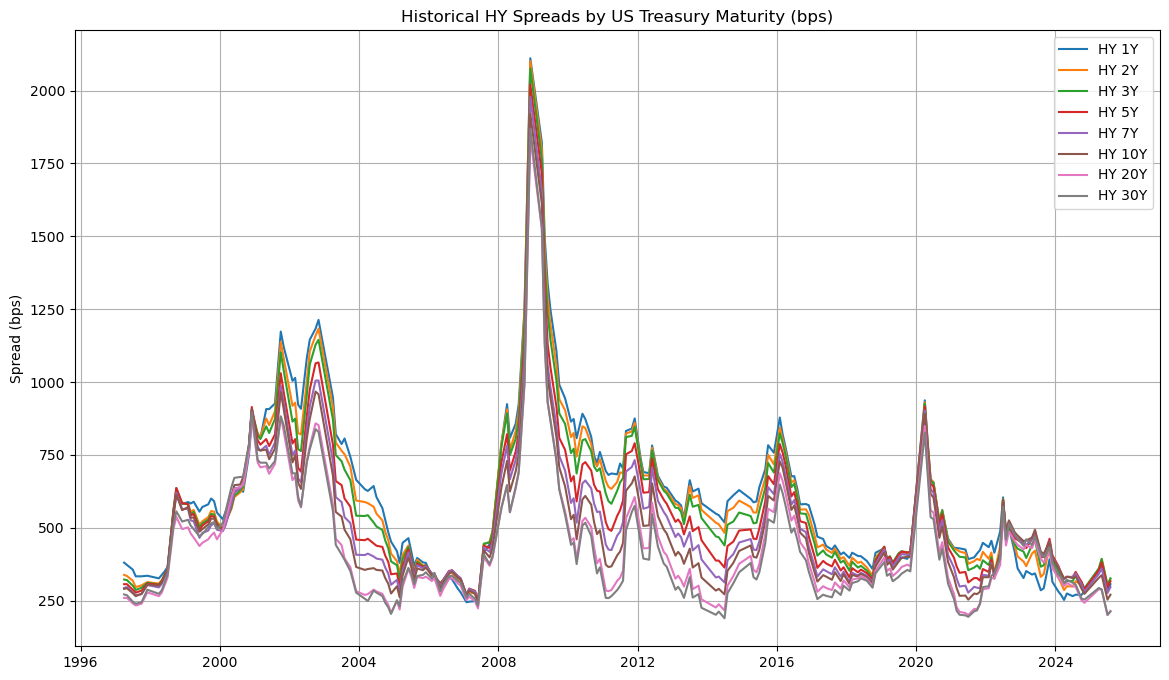

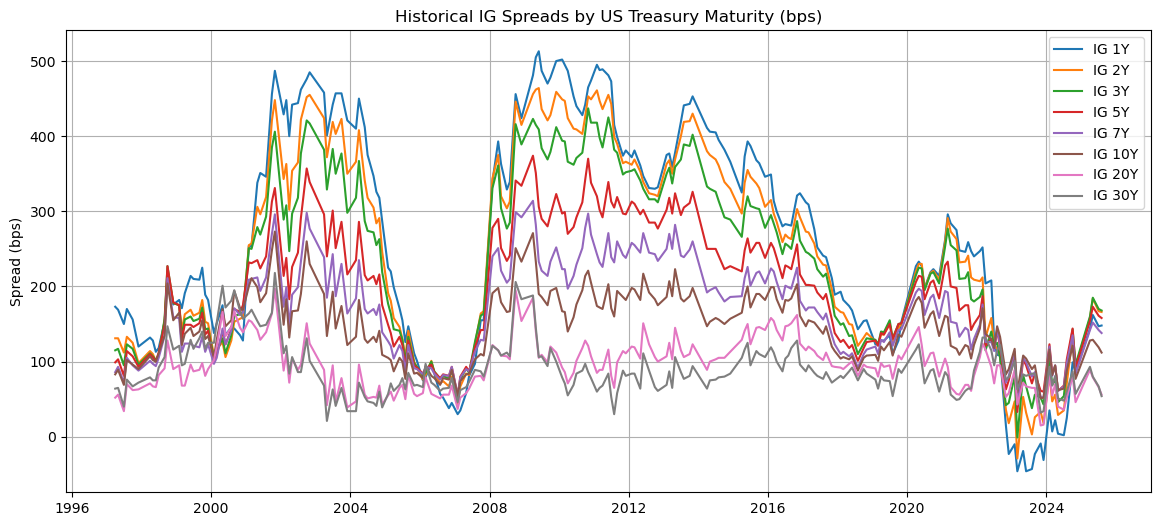

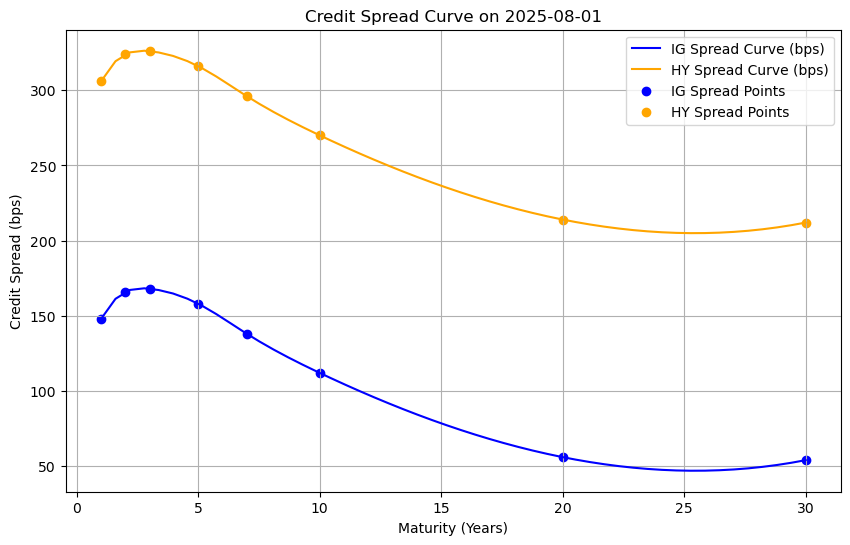


IG Index Metrics:
Spread Duration (yrs): 9.75
DV01 ($): 975.00
P&L +50bps ($): -4875.00
P&L +100bps ($): -9750.00

HY Index Metrics:
Spread Duration (yrs): 9.75
DV01 ($): 975.00
P&L +50bps ($): -4875.00
P&L +100bps ($): -9750.00


In [6]:
df = get_data()
df_spreads = calculate_spreads_maturity(df)
prepare_historical_spreads(df_spreads)
plot_historical_spreads(df_spreads, maturities=[1,2,3,5,7,10,20,30])
plot_credit_spread_curve(df_spreads)
metrics = calculate_risk_metrics(df_spreads)

for idx, m in metrics.items():
    print(f"\n{idx} Index Metrics:")
    for k, v in m.items():
        print(f"{k}: {v:.2f}")
